# 基于决策树算法实现电信用户流失预测任务

任务描述：随着电信行业的不断发展，运营商们越来越重视如何扩大其客户群体。据研究，获取新客户所需的成本远高于保留现有客户的成本，因此为了满足在激烈竞争中的优势，保留现有客户成为一大挑战。对电信行业而言，可以通过数据挖掘等方式来分析可能影响客户决策的各种因素，以预测他们是否会产生流失（停用服务、转投其他运营商等）。

据集：本案例所使用数据集来自Kaggle平台，可以从这里下载。数据集一共提供了7043条用户样本，每条样本包含21列属性，由多个维度的客户信息以及用户是否最终流失的标签组成，客户信息具体如下： 基本信息：包括性别、年龄、经济情况、入网时间等； 开通业务信息：包括是否开通电话业务、互联网业务、网络电视业务、技术支持业务等； 签署的合约信息：包括合同年限、付款方式、每月费用、总费用等。

# 一、引入工具包

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

import graphviz
from sklearn import tree

D:\Anaconda3\envs\Python3.6\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## 二、加载数据

In [2]:
data = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', None)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 三、数据预处理

### 3.1 重复值处理

In [3]:
data.shape

(7043, 21)

In [4]:
data.drop_duplicates().shape

(7043, 21)

可以得出该数据无重复值

### 3.2 缺失值处理

In [5]:
missingDf = data.isnull().sum().sort_values(ascending=False).reset_index()
missingDf.columns = ['feature', 'missing_num']
missingDf['missing_percentage'] = missingDf['missing_num'] / data.shape[0]
missingDf.head()

,feature,missing_num,missing_percentage
0,Churn,0,0.0
1,OnlineSecurity,0,0.0
2,gender,0,0.0
3,SeniorCitizen,0,0.0
4,Partner,0,0.0


统计结果告诉我们数据集中应该没有缺失值，但是可能存在这样的情况：采用 'Null'、'NaN'、' ' 等字符（串）表示缺失。数据集中就有这样一列TotalCharges特征，存在如下所示的11条样本，其特征值为空格字符（' '）：

In [6]:
data[data['TotalCharges'] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [7]:
# 将特征TotalCharges转为数值型
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')

In [8]:
# 使用MonthlyCharges填充TotalCharges
data['TotalCharges'] = data['TotalCharges'].fillna(data['MonthlyCharges']) 

### 3.3 异常值处理

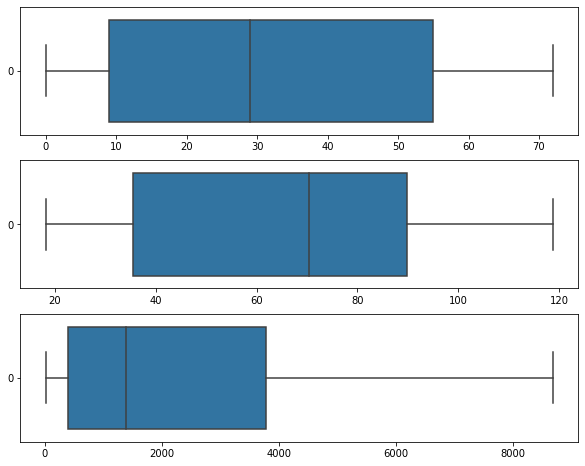

In [9]:
fig = plt.figure(figsize=(10,8))

# tenure
ax1 = fig.add_subplot(3,1,1)
sns.boxplot(data = data['tenure'],orient='h',ax=ax1)

# MonthlyCharges
ax2 = fig.add_subplot(3,1,2)
sns.boxplot(data = data['MonthlyCharges'],orient='h',ax=ax2)

# TotalCharges
ax3 = fig.add_subplot(3,1,3)
sns.boxplot(data = data['TotalCharges'],orient='h',ax=ax3)

## 四、特征工程

### 4.1 删除明显和预测值无关的特征

In [10]:
data.drop(['customerID'],inplace=True,axis=1)
data.shape

(7043, 20)

### 4.2 类别型特征处理

##### NO 和 No internet service意义相同，将其合并

In [11]:
data.loc[data['MultipleLines'] == 'No phone service','MultipleLines'] = 'No'

In [12]:
for fea in ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']:
    data.loc[data[fea] == 'No internet service',fea] = 'No'

##### 将二分类变量转为数值型变量

In [13]:
data['gender'] = (data['gender'] == 'Male').astype(int)
data['gender'].value_counts()

1    3555
0    3488
Name: gender, dtype: int64

In [14]:
for fea in ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',"StreamingMovies","PaperlessBilling",'Churn']:
    data[fea] = data[fea].apply(lambda x :1 if x == 'Yes' else 0)

##### 将三分类变量转为数值型变量

In [15]:
for fea in  ['InternetService', 'Contract', 'PaymentMethod']:
    labels = data[fea].unique().tolist()
    data[fea] = data[fea].apply(lambda x:labels.index(x))

In [16]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,29.85,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,1,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,1,53.85,108.15,1
3,1,0,0,0,45,0,0,0,1,0,1,1,0,0,1,0,2,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,0,70.70,151.65,1


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null int32
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
tenure              7043 non-null int64
PhoneService        7043 non-null int64
MultipleLines       7043 non-null int64
InternetService     7043 non-null int64
OnlineSecurity      7043 non-null int64
OnlineBackup        7043 non-null int64
DeviceProtection    7043 non-null int64
TechSupport         7043 non-null int64
StreamingTV         7043 non-null int64
StreamingMovies     7043 non-null int64
Contract            7043 non-null int64
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null int64
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null int64
dtypes: float64(2), int32(1), int64(17)
memory usage: 1.0 MB


## 五、模型训练

### 5.1 切分特征和标签

In [18]:
X = data.iloc[:,1:]
y = data.iloc[:,0]

### 5.2 样本不均衡问题

In [19]:
y.value_counts()

1    3555
0    3488
Name: gender, dtype: int64

#### 使用上采样对样本进行补充

In [21]:
sm = SMOTE(random_state=20)
X, y = sm.fit_sample(X,y)

In [26]:
pd.Series(y).value_counts()

1    3555
0    3555
dtype: int64

### 5.3 切分训练集和测试集

In [28]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.3,random_state=0)
for i in [X_train,X_test,Y_train,Y_test]:
    i.index = range(i.shape[0])

### 5.4 模型训练

In [29]:
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train,Y_train)
score = clf.score(X_test,Y_test)
score

0.5119549929676512

In [30]:
pred = clf.predict(X_test)

### 5.5 模型评估

取精确率、召回率以及综合两者的F1值，但关注的重点仍然放在召回率上

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score    # 导入精确率、召回率、F1值等评价指标
r = recall_score(Y_test,pred)
r

0.5078053259871441

In [32]:
p = precision_score(Y_test,pred)
p

0.5226843100189036

In [33]:
f1 = f1_score(Y_test,pred)
f1

0.5151374010246856

## 六、模型优化

### 6.1 特征选择